In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image

In [3]:
from constants import *

In [4]:
import matplotlib.pyplot as plt

### Old way of pulling out corpus

In [5]:
with open(f'{CONCAT_DIR}/concat_corpus.utf') as f:
    train_contents = f.read()

In [6]:
train_contents[0:10]

'їPÿ\x07{\x919\x05)\x1c'

In [7]:
import h5py    
import numpy as np    
import json
concat_h5 = h5py.File(f'{CONCAT_DIR}/concat_corpus.h5','r+') 

concat_json = json.load(open(f'{CONCAT_DIR}/concat_corpus.json', 'rb'))

/home/paperspace/anaconda3/envs/music/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [8]:
t = concat_h5['train']

In [9]:
t[:10]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

### One hot encoding

In [10]:
def one_hot(a,c): 
    return np.eye(c)[a]

In [11]:
class MusicDataset(torch.utils.data.Dataset):
    """Face Landmarks dataset."""

    def __init__(self, h5_file, set_type, json_file, timesteps, root_dir):
        self.concat_h5 = h5py.File(f'{root_dir}/{h5_file}','r+')
        self.dataset = self.concat_h5[set_type]
        self.concat_json = json.load(open(f'{root_dir}/{json_file}', 'rb'))
        self.vocab_size = len(self.concat_json['idx_to_token'])+1
        self.data_length = self.dataset.shape[0]
        self.timesteps = timesteps

    def __len__(self):
#         print((self.data_length - self.timesteps)//10)
#         return (self.data_length - self.timesteps)//10
        return (self.data_length // self.timesteps)

    def __getitem__(self, idx):
#         print(np.arange(10)[0:8]) # example
#         print(np.arange(10)[8])
        # (AS) Should not have duplicate sequences. 
        # RBMs do not actually use target value, so no point in repeating next char
#         x = self.dataset[idx:idx+timesteps]
#         y = self.dataset[idx+timesteps]
        
        start = idx*self.timesteps
        x = self.dataset[start:start+self.timesteps]
        y = self.dataset[start+self.timesteps]
#         x_hot = one_hot(x, self.vocab_size)
        return x, y


In [12]:
md = MusicDataset(h5_file='concat_corpus.h5', set_type='train', json_file='concat_corpus.json', timesteps=15, root_dir=CONCAT_DIR)

In [13]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(md,
    batch_size=batch_size)

### Dataset sanity test

In [ ]:
train_iter = enumerate(train_loader)

In [ ]:
i, (x, y) = next(train_iter)
i2, (x2, y2) = next(train_iter)

In [ ]:
md.dataset[:100]

In [ ]:
# a = np.argmax(x[11], axis=1)[:-1]
# b = np.argmax(x[10], axis=1)[1:]
# np.testing.assert_array_equal(a, b)

In [ ]:
# a = np.argmax(x2[0], axis=1)[:-1]
# b = np.argmax(x[-1], axis=1)[1:]
# np.testing.assert_array_equal(a, b)

### Model

In [14]:
def repackage_var(h):
    """Wraps h in new Variables, to detach them from their history."""
    return torch.autograd.Variable(h.data).cuda() if type(h) == torch.autograd.Variable else tuple(repackage_var(v) for v in h)

In [15]:
class StatefulLSTM(torch.nn.Module):
    def __init__(self, scale_size, n_hidden, n_factors, bs, nl):
        super().__init__()
        self.scale_size = scale_size
        self.nl = nl
        self.embedding = torch.nn.Embedding(scale_size, n_factors)
        self.rnn = torch.nn.LSTM(n_factors, n_hidden, nl, dropout=0.5)
        self.l_out = torch.nn.Linear(n_hidden, scale_size)
        self.n_hidden = n_hidden
        self.init_hidden(bs)
        
    def forward(self, notes):
        bs = notes[0].shape[0]
        if self.h[0].size(1) != bs: 
            print('batch size is not same size as original:', bs)
            self.init_hidden(bs)
        emb = self.embedding(notes)
        outp,h = self.rnn(emb, self.h)
        self.h = repackage_var(h)
#         return torch.nn.functional.log_softmax(self.l_out(outp), dim=-1).view(-1, self.scale_size)
        return torch.nn.functional.log_softmax(self.l_out(outp[:, -1, :]), dim=-1)
#         return torch.nn.functional.softmax(self.l_out(outp[:, -1, :]), dim=-1)
    
    def init_hidden(self, bs):
        h1 = torch.autograd.Variable(torch.zeros(self.nl, bs, self.n_hidden))
        h2 = torch.autograd.Variable(torch.zeros(self.nl, bs, self.n_hidden))
        if self._cuda():
            self.h = (h1.cuda(), h2.cuda())
        else:
            self.h = (h1, h2)
            
    def _cuda(self):
        return next(self.parameters()).is_cuda

### Training

In [16]:
m = StatefulLSTM(md.vocab_size, n_hidden=256, n_factors=10, bs=batch_size, nl=2).cuda()

In [17]:
train_op = torch.optim.Adam(m.parameters(), lr=1e-3)

In [18]:
loss_fn = torch.nn.NLLLoss()

In [19]:
display_step = 100
training_steps = 100
for step in range(training_steps):
# for step in tqdm(range(training_steps)):
    for i, (data,target) in enumerate(train_loader):
        data, target = torch.autograd.Variable(data.long().cuda()), torch.autograd.Variable(target.long().cuda())
        m.zero_grad()
        forward = m(data)
        loss = loss_fn(forward, target)
        loss.backward()
        train_op.step()
#     if (step % display_step == 0):
    print(f'Step: {step} Loss: {loss.data[0]}')

batch size is not same size as original: 15
Step: 0 Loss: 2.5683021545410156
Step: 1 Loss: 2.3499510288238525
Step: 2 Loss: 2.1287286281585693
Step: 3 Loss: 2.022139072418213
Step: 4 Loss: 2.0011024475097656
Step: 5 Loss: 1.9984527826309204
Step: 6 Loss: 1.926031231880188
Step: 7 Loss: 1.8813749551773071
Step: 8 Loss: 1.7983454465866089
Step: 9 Loss: 1.7398408651351929
Step: 10 Loss: 1.7155526876449585
Step: 11 Loss: 1.6044965982437134
Step: 12 Loss: 1.6079603433609009
Step: 13 Loss: 1.4806982278823853
Step: 14 Loss: 1.5355020761489868
Step: 15 Loss: 1.3822604417800903
Step: 16 Loss: 1.2611007690429688
Step: 17 Loss: 1.3176378011703491
Step: 18 Loss: 1.1455236673355103
Step: 19 Loss: 1.1275262832641602
Step: 20 Loss: 1.0927006006240845
Step: 21 Loss: 1.0568561553955078
Step: 22 Loss: 1.036879539489746
Step: 23 Loss: 0.960381805896759
Step: 24 Loss: 0.9074965119361877
Step: 25 Loss: 0.9171072840690613
Step: 26 Loss: 0.8896744847297668
Step: 27 Loss: 0.8364683985710144
Step: 28 Loss: 0.7

### Generate music

In [ ]:
gen_song = encoded_songs[ind][:timesteps].tolist() # TODO explore different (non-random) seed options

Need to have unknown state 0?

In [20]:
timesteps = md.timesteps
output_size = md.vocab_size

In [21]:
gen_song = md.dataset[:timesteps]

In [22]:
def generate_sequence(song, seq_length):
    full_song = song.tolist()
    # generate music!
    m.init_hidden(batch_size)
    for i in range(seq_length):
        seed = np.array([full_song[-timesteps:]])
        # Use our RNN for prediction using our seed! 
        seed_v = torch.autograd.Variable(torch.from_numpy(seed).long()).cuda()
    #     seed_v = torch.autograd.Variable(torch.from_numpy(np.argmax(seed, axis=1)).long()).cuda() # for onehot
        predict_probs = m(seed_v)

        percentage_prob = (np.e ** predict_probs.data.cpu().numpy())
        # Define output vector for our generated song by sampling from our predicted probability distribution
        
    #     sampled_note = np.random.choice(range(md.vocab_size), p=percentage_prob[0]) # TODO
        sampled_note = np.argmax(percentage_prob)
    #     print('Sampled_note:', sampled_note)
        full_song.append(sampled_note)
    return full_song
    


In [23]:
import decode

In [24]:
def decode_output(output_idx):
    idx2token = md.concat_json['idx_to_token']
    token_list = list(map(lambda x: idx2token.get(str(x), ''), output_idx))
    return decode_token(token_list)

def decode_token(token_list):
    if (token_list[0] != START_DELIM):
        token_list.insert(0, START_DELIM)
    token_str = ''.join(token_list)
    with open(f'{SCRATCH_DIR}/utf_to_txt.json', 'r') as f:
        utf_to_txt = json.load(f)
    score, stream = decode.decode_string(utf_to_txt, token_str)
    return token_str, score, stream

# test = [idx2token[f'{x}'] for x in seq_arr]; test

In [26]:
song_seed = md.dataset[:md.timesteps]
generated_idxs = generate_sequence(song_seed, 500)

batch size is not same size as original: 15


In [27]:
token_str, score, stream = decode_output(generated_idxs)

/home/paperspace/music_rnn/bachbot/decode.py:133: Music21DeprecationWarning: Note._setMidi was deprecated on May 2014 and will disappear at or after September 2017, v.5. use pitch.midi instead
  note.midi = note_tuple[0]


In [28]:
token_str

'їPÿ\x07{\x919\x05)\x1c\x91\x91\x91Ûÿ\x07Hí\x91áÿ\x9eH\x91çïH\x91\x84\x91\x84\x91\x05ïh\x91\x17ïï%\x91á\x9e+H\x91çï)ã%\x91\x84ћїç)h\x91\x91\x17ïæãB\x91\x84\x91çàÕÒ\x07Ù\x91\x84\x91çî\x07{\x1c\x91\x91\x17à)%\x91\x17ï+µ\x91\x84\x91\x05ï\x9a\x91\x91\x17)H\x91þî{çàï)%\x91á\x9e\x07{\x1c\x91á+H\x91çï)%\x91þ\x9et\x91\x17àï)%\x91ç\x17ï\x91\x91çï)%\x91\x91\x17)\x1c\x91\x91Õh\x91î\x07h\x91þ\x9eH\x91çà))%\x91\x84\x91\x84\x91çïæ~Ù\x91\x84\x91ÿ\x07{µ\x91çàï%\x91\x91ç\x05ÐÈ\x91á,\x9et\x1c\x91áá,H\x91áî\x07{\x91þ\x9eH\x91çï\x1c\x91Pÿ\x9e{h\x91\x05\x9eh\x91á\x9e\x07{í\x91á\x9eH\x91çàà)\x1c\x91\x91\x05ïï%\x91á\x9etH\x91ç\x05Õ+)%\x91\x17ïæ \x91\x84\x91\x91\x17)è\x91\x91Õ)\x1c\x91ç\x9e\x07{\x91çà)%\x91á\x9etH\x91ç\x05ï)%\x91á\x9et\x91FàïB\x91\x84\x91\x91\x91çï\x1c\x91ç\x9e\x07{\x1c\x91PÄ\x91\x91çêH\x91çï\x1c\x91çïæ%\x91á\x9eH\x91çï\x1c\x91\x17ïæB\x91\x91\x91çï\x1c\x91\x84\x91\x84\x91\x1c\x91\x91{\x11§\x91ÿ\x07{µ\x91ç\x05àï\x9a\x91\x91\x17à)%\x91\x91ç\x05àÐ\x9a\x91\x91\x17à)\x9a\x91\x17ïh\x91\x84\x91\x05ï

### For testing stuff

In [ ]:
with open(f'{SCRATCH_DIR}/utf_to_txt.json', 'r') as f:
    utf_to_txt = json.load(f)

In [ ]:
test_str = train_contents[:200]

In [ ]:
test_str = open(f'{SCRATCH_DIR}/BWV-400-nomask-fermatas.utf', 'r').read()[:200]

In [ ]:
token_str, score, stream = decode_token(test_str)

In [ ]:
stream.elements[:10]

### Evaluate stream

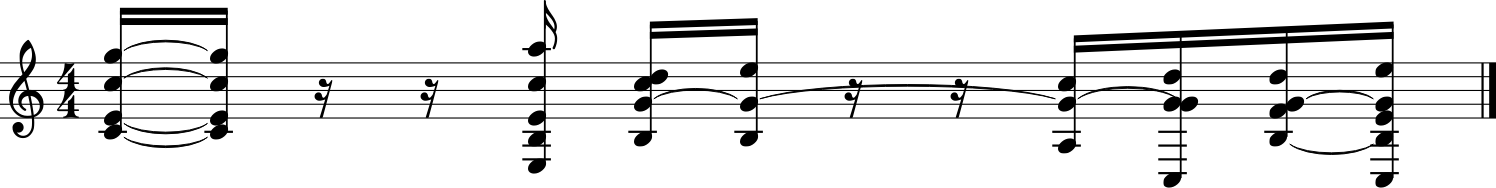

In [29]:
stream.show()

In [30]:
fp = stream.write('midi', fp=f'{OUT_DIR}/testout.midi')

In [31]:
fp = stream.write('xml', fp=f'{OUT_DIR}/testout.xml')

In [ ]:
from IPython.lib.display import FileLink
FileLink('../data/bachbot/out/testout.midi')